# torch-cam可解释性分析可视化

同济子豪兄 https://space.bilibili.com/1900783

代码运行云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1

2022-8-19

## 导入工具包

In [1]:
import os
import time

import numpy as np
import pandas as pd

import cv2 # opencv-python
from PIL import Image, ImageFont, ImageDraw
from tqdm import tqdm # 进度条

import matplotlib.pyplot as plt
%matplotlib inline
import torchcam
import torch
from torchcam.utils import overlay_mask
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda:0


## 导入中文字体

In [14]:
# 下载中文字体文件
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [24]:
import requests

# The URL of the file you want to download
url = 'https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf'
filename = url.split('/')[-1]  # Extract the filename

# Make a GET request to download the file
response = requests.get(url)

# Save the file content to a file in the current working directory
if response.status_code == 200:
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded {filename} successfully.")
else:
    print("Failed to download the file.")


SSLError: HTTPSConnectionPool(host='zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com', port=443): Max retries exceeded with url: /20220716-mmclassification/dataset/SimHei.ttf (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))

In [2]:
# 导入中文字体，指定字号
font = ImageFont.truetype('SimHei.ttf', 20)

## 导入训练好的模型

In [73]:
model = torch.load(r'E:\MV-Code-202018010103-Lucy\main\Train_Custom_Dataset\图像分类\3-【Pytorch】迁移学习训练自己的图像分类模型\checkpoint\best-0.986.pth.pth')
model = model.eval().to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\MV-Code-202018010103-Lucy\\main\\Train_Custom_Dataset\\图像分类\\3-【Pytorch】迁移学习训练自己的图像分类模型\\checkpoint\\best-0.986.pth.pth'

## 载入类别

In [74]:
idx_to_labels_cn = np.load(r'E:\MV-Code-202018010103-Lucy\main\Train_Custom_Dataset\图像分类\3-【Pytorch】迁移学习训练自己的图像分类模型\idx_to_labels.npy', allow_pickle=True).item()

In [75]:
idx_to_labels_cn

{0: 'parasitized', 1: 'uninfected'}

## 导入可解释性分析方法

In [76]:
import torchcam
from torchcam.methods import CAM
# CAM GradCAM GradCAMpp ISCAM LayerCAM SSCAM ScoreCAM SmoothGradCAMpp XGradCAM

cam_extractor = CAM(model)

## 预处理

In [77]:
from torchvision import transforms
# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 获取摄像头的一帧画面

In [96]:
# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

time.sleep(1)

success, img_bgr = cap.read()
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

In [97]:
img_bgr.shape

(480, 640, 3)

In [98]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB

In [99]:
img_pil = Image.fromarray(img_rgb)

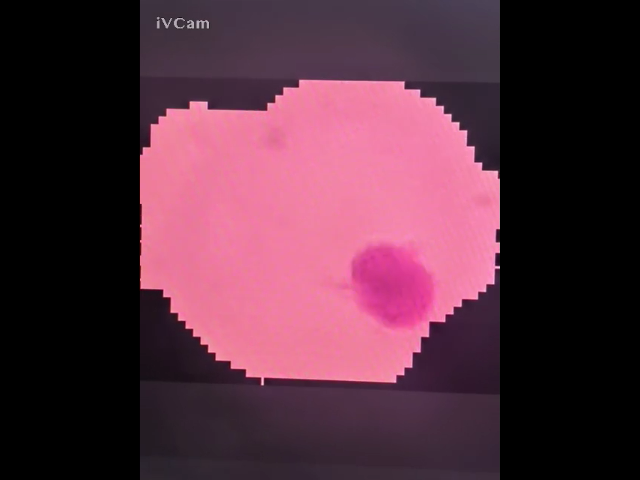

In [100]:
img_pil

In [101]:
# 可视化热力图的类别ID，如果为 None，则为置信度最高的预测类别ID
# show_class_id = 761
show_class_id = None

In [102]:
# 前向预测
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
pred_logits = model(input_tensor)
pred_top1 = torch.topk(pred_logits, 1)
pred_id = pred_top1[1].detach().cpu().numpy().squeeze().item()

In [103]:
# 可视化热力图的类别ID，如果不指定，则为置信度最高的预测类别ID
if show_class_id:
    show_id = show_class_id
else:
    show_id = pred_id
    show_class_id = pred_id

In [104]:
# 生成可解释性分析热力图
activation_map = cam_extractor(show_id, pred_logits)
activation_map = activation_map[0][0].detach().cpu().numpy()
result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7)

In [105]:
# 在图像上写字
draw = ImageDraw.Draw(result)

# 在图像上写中文
text_pred = 'Pred Class: {}'.format(idx_to_labels_cn[pred_id])
text_show = 'Show Class: {}'.format(idx_to_labels_cn[show_class_id])

# 文字坐标，中文字符串，字体，rgba颜色
draw.text((50, 100), text_pred, font=font, fill=(255, 0, 0, 1))
draw.text((50, 200), text_show, font=font, fill=(255, 0, 0, 1))

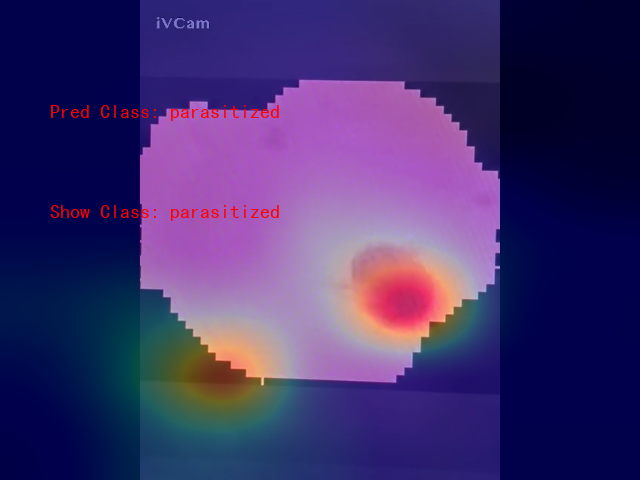

In [106]:
result

## 图像分类预测函数

In [94]:
def process_frame(img, show_class_id=None, Chinese=True):
    '''
    输入摄像头画面bgr-array和用于绘制热力图的类别ID，输出写字的热力图bgr-array
    如果不指定类别ID，则为置信度最高的预测类别ID
    '''
    
    img_bgr = img
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR 转 RGB
    img_pil = Image.fromarray(img_rgb) # array 转 pil
    input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
    pred_logits = model(input_tensor) # 执行前向预测，得到所有类别的 logit 预测分数
    pred_top1 = torch.topk(pred_logits, 1)
    pred_id = pred_top1[1].detach().cpu().numpy().squeeze().item()
    
    # 可视化热力图的类别ID，如果为 None，则为置信度最高的预测类别ID
    if show_class_id:
        show_id = show_class_id
    else:
        show_id = pred_id
        show_class_id = pred_id
        
    # 生成可解释性分析热力图
    activation_map = cam_extractor(show_id, pred_logits)
    activation_map = activation_map[0][0].detach().cpu().numpy()
    result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7)
    
    # 在图像上写字
    draw = ImageDraw.Draw(result)

    # 在图像上写英文
    text_pred = 'Pred Class: {}'.format(idx_to_labels_cn[pred_id])
    text_show = 'Show Class: {}'.format(idx_to_labels_cn[show_class_id])
    # 文字坐标，中文字符串，字体，rgba颜色
    draw.text((50, 100), text_pred, font=font, fill=(255, 0, 0, 1))
    draw.text((50, 200), text_show, font=font, fill=(255, 0, 0, 1))
        
    img_rgb = np.array(result)
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    return img_bgr

## 调用摄像头获取每帧（模板）

In [95]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    # 获取画面
    success, frame = cap.read()
    if not success:
        print('Error')
        break
    
    ## !!!处理帧函数
    frame = process_frame(frame) # 类别：最高置信度预测类别
    # frame = process_frame(frame, show_class_id=11) # 类别：猕猴桃
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)

    if cv2.waitKey(1) in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

## 小练习

1.将类别设置为固定类别。

2.对不同的层进行可解释性分析。

3.用多个同类别物体（例如多个猕猴桃）做测试。

4.最耗时的是哪一部分？如何对实时预测做进一步加速？